In [24]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [25]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from hcomp_paper_viz import *

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from qualityBaseline import compute_self_BBvals
print "generate baseline comparisons"
compute_self_BBvals(compute_metrics=['simple','area'])
retreival_df = compute_best_average_heuristics_workers_baselines(rerun_existing=True)

generate baseline comparisons


/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


# Retreival based heuristic models

In [209]:
sample_clust = pd.read_csv("all_sample_cluster_worker.csv",index_col=0)
best_clust = pd.read_csv("best_clust_picking.csv",index_col=0)

In [210]:
best_clust.head()

,num_workers,sample_num,objid,clust,sample
2205,5,0,1,0,5workers_rand0
2208,5,0,2,-1,5workers_rand0
2209,5,0,3,-1,5workers_rand0
2210,5,0,4,0,5workers_rand0
2213,5,0,5,-1,5workers_rand0


-  if we only pick from the best cluster, if no clustering done then retain the same worker performance as before

In [222]:
retreival_df= pd.read_csv("pixel_em/individual_worker_performance.csv")

In [223]:
no_cluster_retreival_df = retreival_df[retreival_df["clust"]==-1]

In [225]:
cluster_retreival_df = retreival_df[((retreival_df["clust"]!=-1) & (retreival_df["objid"].isin(clustObj)))|((retreival_df["clust"]==-1) & (~retreival_df["objid"].isin(clustObj)))]

In [74]:
outfile = "pixel_em/best_cluster_individual_worker_performance.csv"
# if os.path.exists(outfile) and not rerun_existing:
#     return pd.read_csv(outfile)
metric_keys = ['Precision [Self]', u'Recall [Self]','Jaccard [Self]','FPR% [Self]','FNR% [Self]']
computed_wrt_gt = pd.read_csv("../data/computed_my_COCO_BBvals.csv",index_col=0)
sample_lst = sample_specs.keys()
obj_clusters = clusters()
df_data =[]
for batch in sample_lst:
    for objid in object_lst:
        if str(objid) in obj_clusters[batch]:
            clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
        else:
            clusts = ["-1"]
        for clust in clusts:
            hydir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, batch, objid)
            if clust=="-1":
                worker_ids = json.load(open(hydir+"worker_ids.json"))
            else:
                worker_ids= json.load(open(hydir+"/clust{}/worker_ids.json".format(clust)))

            selected_annotations = computed_wrt_gt[(computed_wrt_gt["object_id"]==objid)&(computed_wrt_gt["worker_id"].isin(worker_ids))]
            best_num_pt_p,best_num_pt_r,best_num_pt_j,best_num_pt_fnr,best_num_pt_fpr = selected_annotations.loc[selected_annotations["Num Points"].idxmax()][metric_keys]
            best_ar_p,best_ar_r,best_ar_j,best_ar_fnr,best_ar_fpr = selected_annotations.loc[selected_annotations["Area Ratio"].idxmax()][metric_keys]
            max_p,max_r,max_j,max_fpr,max_fnr = selected_annotations.loc[selected_annotations["Jaccard [Self]"].idxmax()][metric_keys]
            avrg_p,avrg_r,avrg_j,avrg_fpr,avrg_fnr =  selected_annotations.mean()[metric_keys]
            df_data.append([batch, objid,clust,
                            best_num_pt_p,best_num_pt_r,best_num_pt_j,best_num_pt_fnr,best_num_pt_fpr,\
                             best_ar_p,best_ar_r,best_ar_j,best_ar_fnr,best_ar_fpr,\
                            avrg_p,avrg_r,avrg_j,avrg_fpr,avrg_fnr,max_p,\
                            max_r,max_j,max_fpr,max_fnr])
df = pd.DataFrame(df_data,columns=["sample","objid","clust",
                "P [NumPt]","R [NumPt]","J [NumPt]","FNR% [NumPt]","FPR% [NumPt]",
                "P [AreaRatio]","R [AreaRatio]","J [AreaRatio]","FNR% [AreaRatio]","FPR% [AreaRatio]",
                "P [AvrgWorker]","R [AvrgWorker]","J [AvrgWorker]","FNR% [AvrgWorker]","FPR% [AvrgWorker]",
                "P [BestWorker]","R [BestWorker]","J [BestWorker]","FNR% [BestWorker]","FPR% [BestWorker]"])
df["num_workers"]=df["sample"].apply(lambda x: int(x.split("workers")[0]))
df.to_csv(outfile,index=None)

0
0


IOError: [Errno 2] No such file or directory: '/home/jlee782/hcomp_paper_seg/analysis/pixel_em/25workers_rand0/obj2//clust0/worker_ids.json'

In [116]:

# vision_performance.loc[vision_performance["j"].idxmax()]
# plt.plot(y*vision_performance[vision_performance["thresh"]==0.2]["j"].values[0],label="vision@0.2")
# plt.plot(y*vision_performance[vision_performance["thresh"]==0.5]["j"].values[0],label="vision@0.5")
# plt.plot(y*vision_performance[vision_performance["thresh"]==0.8]["j"].values[0],label="vision@0.8")


In [252]:
algoMap={
    'NumPt':'orange',
    'AreaRatio':'green',
    'AvrgWorker':'blue',
    'BestWorker':'red'
}

In [253]:
metric_J_baselines

['J [NumPt]', 'J [AreaRatio]', 'J [AvrgWorker]', 'J [BestWorker]']

In [254]:
algoJ

'J [Area Ratio]'

In [255]:
NworkerPerformance['J [AreaRatio]']

num_workers
5     0.789060
10    0.729515
15    0.700575
20    0.682922
25    0.653007
30    0.640720
Name: J [AreaRatio], dtype: float64

In [260]:
algoJ=='J [AreaRatio]'

True

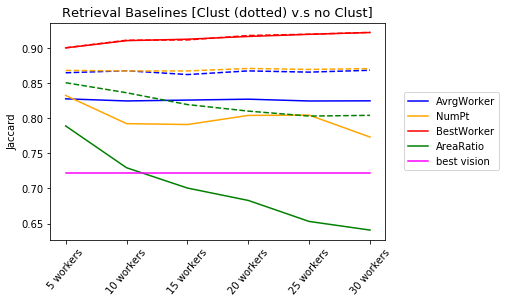

In [265]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
for algo in algoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),label=algo,color=algoMap[algo])

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
for algo in  algoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),linestyle='--',color=algoMap[algo])

    
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
vision_performance = vision.groupby(["thresh","k"],as_index=False)[['p', 'r', 'j', 'fpr', 'fnr']].mean()
plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")
vision_performance = vision.groupby(["thresh","k"],as_index=False)[['p', 'r', 'j', 'fpr', 'fnr']].mean()
max_vision_k_thresh =vision_performance.loc[vision_performance["j"].idxmax()]["j"]
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Retrieval Baselines [Clust (dotted) v.s no Clust]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

In [282]:
df =  compile_all_algo_PRJs()
best_df =  compile_all_algo_PRJs(filter_best=True)

In [291]:
print len(best_df) , "--> should be ",31*46
print len(df), "--> should be ",31*(46+len(clust_df.objid.unique()))

1235 --> should be  1426
1871 --> should be  2201


In [28]:
MV_clust = pd.read_csv("pixel_em/MV_full_PRJ_table.csv")
best_clust_df = MV_clust.loc[MV_clust.groupby(["num_workers","sample_num","objid"])["jaccard"].idxmax()]
best_clust_df = best_clust_df.drop(['precision','recall','jaccard'],axis=1)
best_clust_df = best_clust_df.rename(columns={'cluster':'clust'})
# There can only be one best cluster for every sample objid
assert int(best_clust_df.groupby(["num_workers","sample_num","objid"]).count()["clust"].unique())==1
best_clust_df["sample"]=best_clust_df.apply(lambda x: "{}workers_rand{}".format(int(x["num_workers"]),int(x["actualNworkers"])),axis=1)

In [29]:
best_clust = pd.read_csv("best_clust_picking.csv")

Number of objects: 21


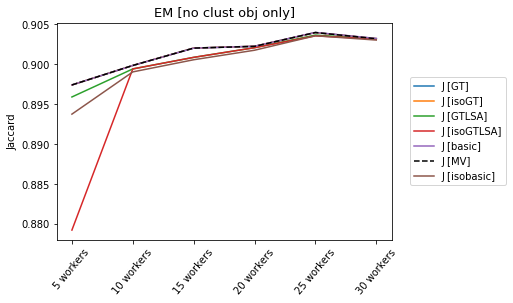

In [30]:
df_noClust = df[(df["clust"]==-1)]
print "Number of objects:",len(df_noClust.objid.unique())
Nworker_performance = df_noClust.groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
# original "whole" MV PRJ for every object table --> MV_noClust : MV with no clustering

for algo in metric_J:
    if '[MV]' in algo:
        plt.plot(np.array(Nworker_performance[algo]),label=algo,color="black",linestyle="--")
    else:
        plt.plot(np.array(Nworker_performance[algo]),label=algo)

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("EM [no clust obj only]",fontsize=13)

Number of objects: 21


(0.89, 0.905)

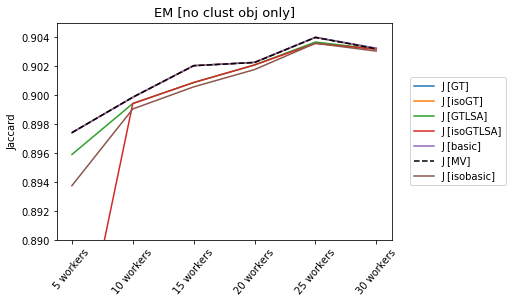

In [31]:
df_noClust = best_df[(best_df["clust"]==-1)]
print "Number of objects:",len(df_noClust.objid.unique())
Nworker_performance = df_noClust.groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
# original "whole" MV PRJ for every object table --> MV_noClust : MV with no clustering

for algo in metric_J:
    if '[MV]' in algo:
        plt.plot(np.array(Nworker_performance[algo]),label=algo,color="black",linestyle="--")
    else:
        plt.plot(np.array(Nworker_performance[algo]),label=algo)

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("EM [no clust obj only]",fontsize=13)
plt.ylim(0.89,0.905)

In [32]:
len(df[df["P [isoGTLSA]"]==-1])

208

In [33]:
# df = df[df["P [isoGTLSA]"]!=-1]
# best_df = best_df[best_df["P [isoGTLSA]"]!=-1]

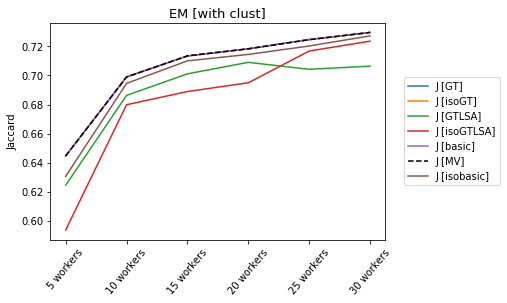

In [34]:
clustObj=clust_df.objid.unique()

df_withClust = df[(((df["clust"]==-1) &(df["objid"].isin(noClust_obj)))| ((df["clust"]!=-1) & (df["objid"].isin(clustObj))))]
Nworker_performance = df_withClust.groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
for algo in metric_J:
    if '[MV]' in algo:
        plt.plot(np.array(Nworker_performance[algo]),label=algo,color="black",linestyle="--")
    else:
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("EM [with clust]",fontsize=13)

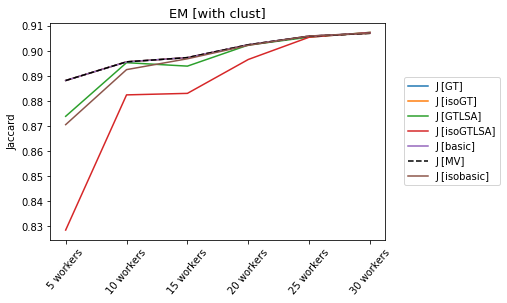

In [35]:
clustObj=clust_df.objid.unique()

df_withClust = best_df[(((best_df["clust"]==-1) &(best_df["objid"].isin(noClust_obj)))| ((best_df["clust"]!=-1) & (best_df["objid"].isin(clustObj))))]
Nworker_performance = df_withClust.groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
for algo in metric_J:
    if '[MV]' in algo:
        plt.plot(np.array(Nworker_performance[algo]),label=algo,color="black",linestyle="--")
    else:
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("EM [with clust]",fontsize=13)

In [137]:
df = pd.read_csv("pixel_em/isobasic_full_PRJ_table.csv")

df[(df["num_workers"]==5)&(df["sample_num"]==0)&(df["objid"]==1)]

,num_workers,actualNworkers,sample_num,objid,clust,precision,recall,jaccard,FPR%,FNR%
900,5,5,0,1,0,0.975025,0.978078,0.954173,0.233439,2.192178
901,5,0,0,1,1,-1.000000,0.000000,0.000000,0.000000,100.000000
902,5,5,0,1,-1,0.975025,0.978078,0.954173,0.233439,2.192178


In [136]:
df = pd.read_csv("pixel_em/MV_full_PRJ_table.csv")

df[(df["num_workers"]==5)&(df["sample_num"]==0)&(df["objid"]==1)]

,num_workers,actualNworkers,sample_num,objid,clust,precision,recall,jaccard,FPR%,FNR%
945,5,5,0,1,0,0.977603,0.980179,0.958651,0.209241,1.982126
946,5,0,0,1,1,-1.000000,0.000000,0.000000,0.000000,100.000000
947,5,5,0,1,-1,0.977603,0.980179,0.958651,0.209241,1.982126


In [ ]:
df =  compile_all_algo_PRJs()
best_df =  compile_all_algo_PRJs(filter_best=True)

In [195]:
df = pd.read_csv("pixel_em/all_PRJ_table.csv",index_col=0)

In [193]:
df[(df["num_workers"]==5)&(df["sample_num"]==0)&(df["objid"]==1)]

,num_workers,actualNworkers,sample_num,objid,clust,P [MV],R [MV],J [MV],FPR% [MV],FNR% [MV],...,P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],FPR% [isoGTLSA],FNR% [isoGTLSA],P [isobasic],R [isobasic],J [isobasic],FPR% [isobasic],FNR% [isobasic]
675,5,5,0,1,0,0.977603,0.980179,0.958651,0.209241,1.982126,...,0.975025,0.978078,0.954173,0.233439,2.192178,0.975025,0.978078,0.954173,0.233439,2.192178
676,5,0,0,1,1,-1.000000,0.000000,0.000000,0.000000,100.000000,...,-1.000000,0.000000,0.000000,0.000000,100.000000,-1.000000,0.000000,0.000000,0.000000,100.000000


# Greedy Results

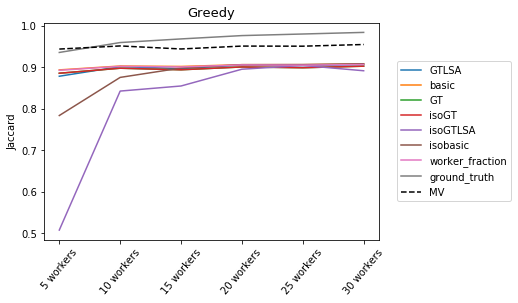

In [190]:
greedy_df = pd.read_csv("all_greedy_result.csv")
greedy_df["num_workers"]=greedy_df.apply(lambda x:int(x["sample"].split("workers")[0]),axis=1)
greedy_df["sample_num"] = greedy_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
greedy_df = filter_best_clust(greedy_df,best_clust_df)

MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv")
MV = filter_best_clust(MV,best_clust_df)
for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA","isobasic","worker_fraction","ground_truth"]:
    plt.plot(np.array(greedy_df[greedy_df["algo"]==algo].groupby(["num_workers"]).mean()["j"]),label=algo)
plt.plot(np.array(MV.groupby("num_workers")["precision"].mean()),label="MV",color="black",linestyle="--")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Greedy",fontsize=13)
# plt.ylim(0.85,0.9)

# Relationship between actual number of workers and how much in the cluster is actually ran

In [39]:
df["ratio_Nworker"]=df["actualNworkers"]/df["num_workers"]

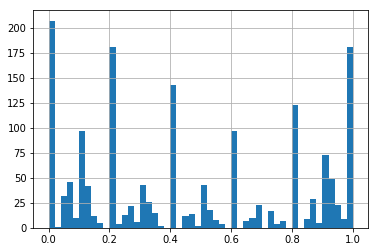

In [43]:
# df["ratio_Nworker"].hist()
df[df["clust"]!=-1]["ratio_Nworker"].hist(bins=50)

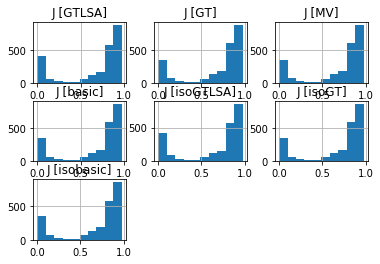

In [56]:
a = df_withClust[metric_J].hist()

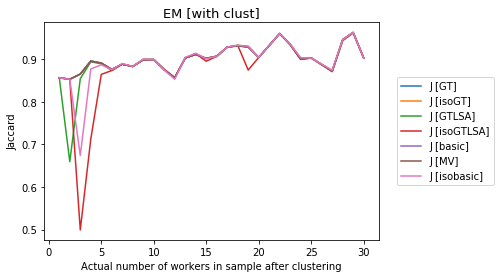

In [58]:
clustObj=clust_df.objid.unique()

df_withClust = best_df[(((best_df["clust"]==-1) &(best_df["objid"].isin(noClust_obj)))| ((best_df["clust"]!=-1) & (best_df["objid"].isin(clustObj))))]

metric_J = [metric for metric in metric_keys if 'J' in metric ]
for algo in metric_J:
    #plt.plot(df_withClust["actualNworkers"],df_withClust[algo],'o',label=algo)
    plt.plot(df_withClust.groupby(["actualNworkers"]).mean()[algo],label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xlabel("Actual number of workers in sample after clustering")
# plt.xticks(rotation=50)
plt.title("EM [with clust]",fontsize=13)

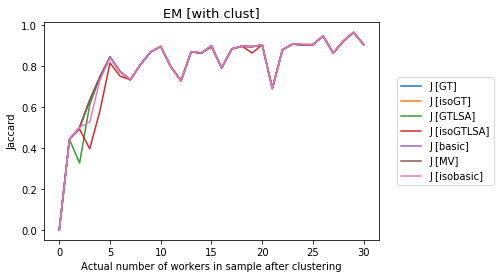

In [59]:
clustObj=clust_df.objid.unique()

df_withClust = df[(((df["clust"]==-1) &(df["objid"].isin(noClust_obj)))| ((df["clust"]!=-1) & (df["objid"].isin(clustObj))))]

metric_J = [metric for metric in metric_keys if 'J' in metric ]
for algo in metric_J:
    #plt.plot(df_withClust["actualNworkers"],df_withClust[algo],'o',label=algo)
    plt.plot(df_withClust.groupby(["actualNworkers"]).mean()[algo],label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xlabel("Actual number of workers in sample after clustering")
# plt.xticks(rotation=50)
plt.title("EM [with clust]",fontsize=13)

# Gt-est by best worker picking based on worker quality, also correlation with individual worker

In [120]:
from scipy.stats  import pearsonr
from scipy.stats import linregress

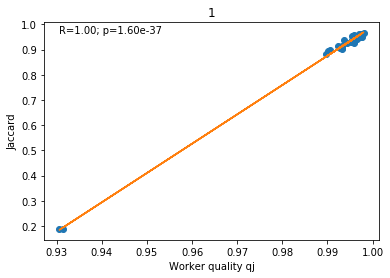

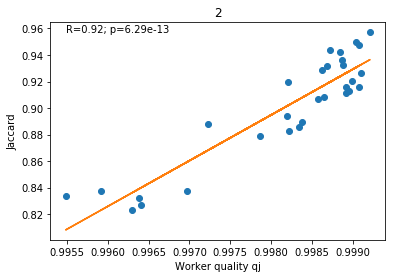

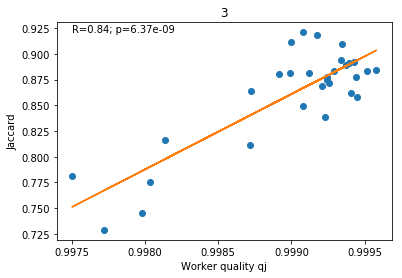

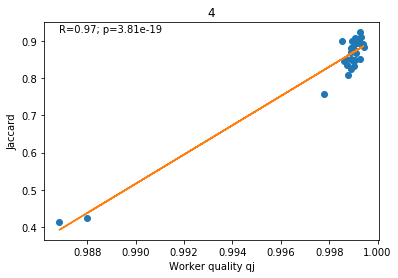

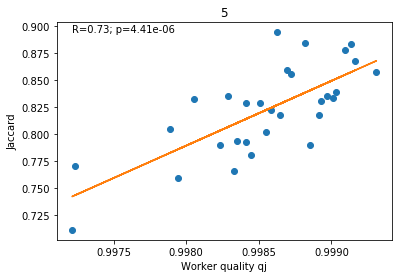

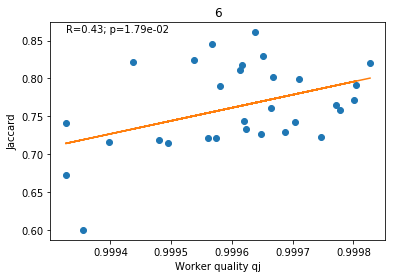

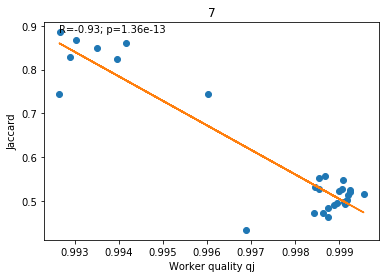

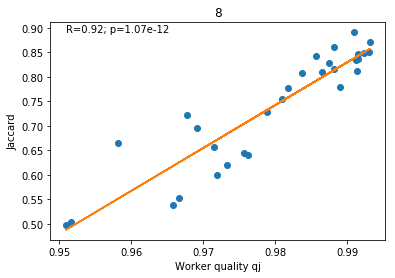

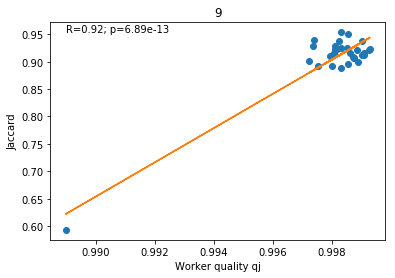

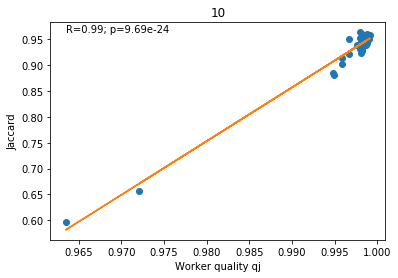

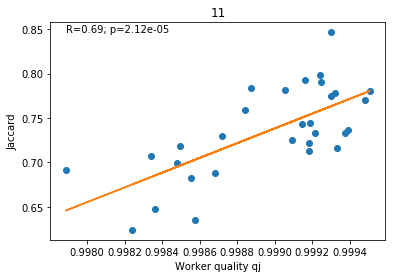

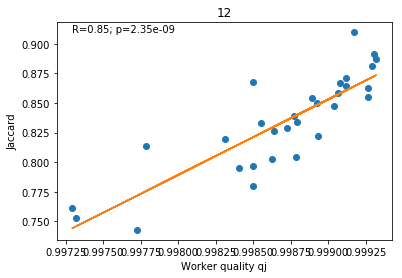

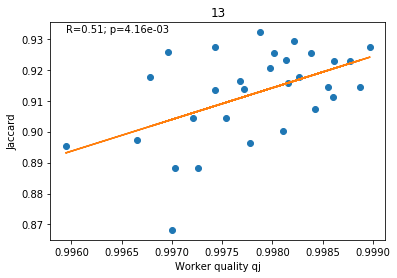

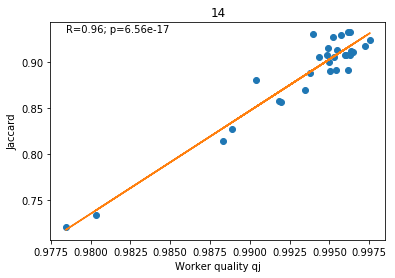

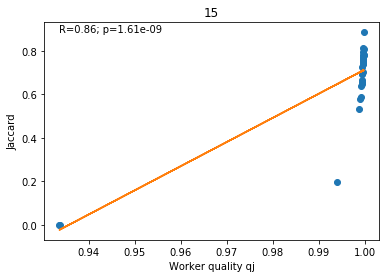

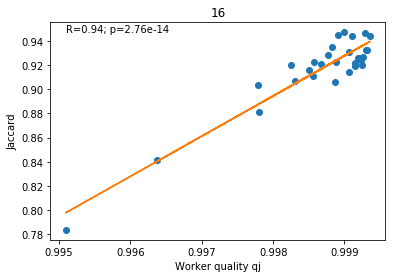

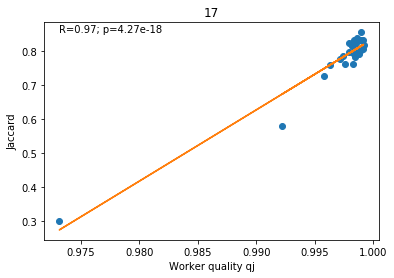

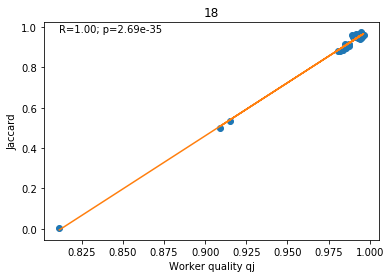

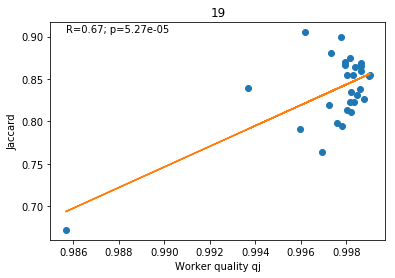

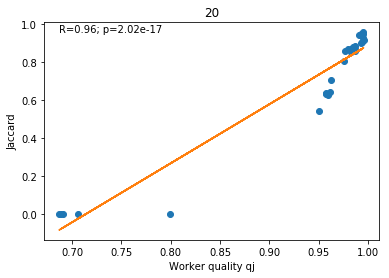

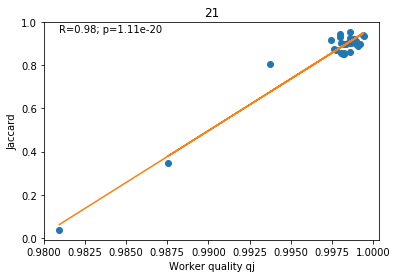

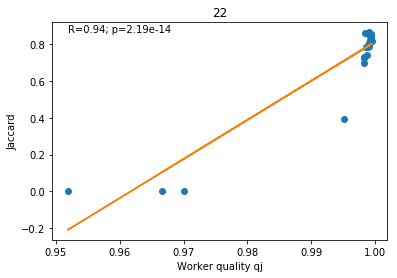

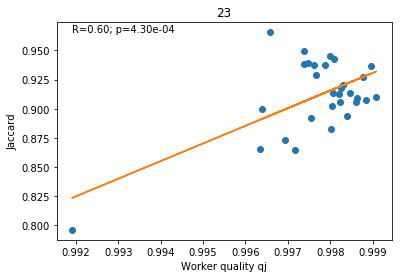

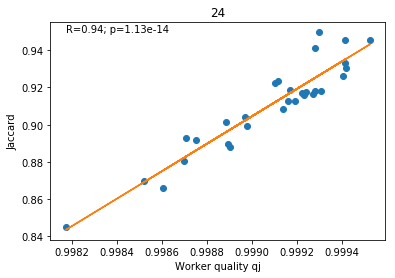

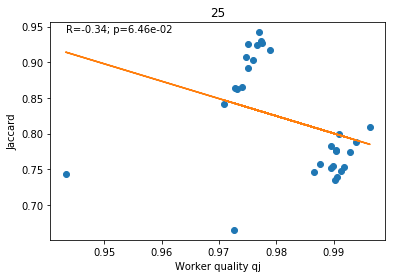

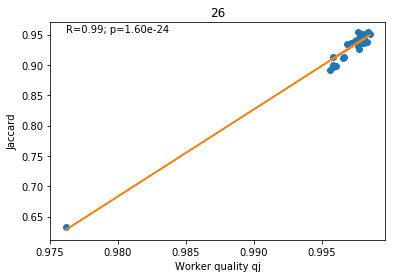

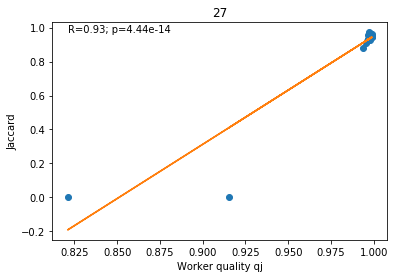

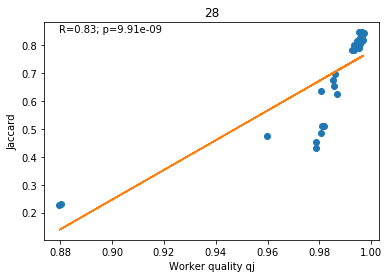

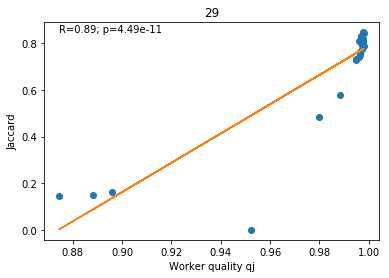

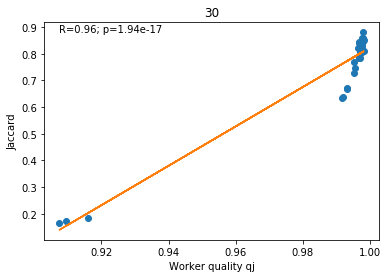

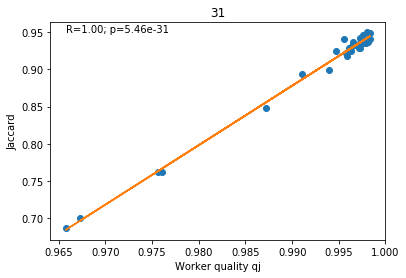

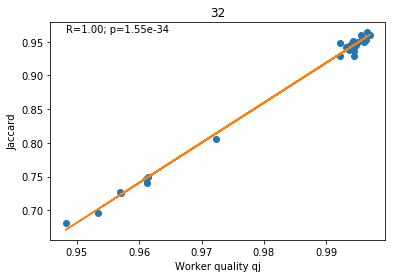

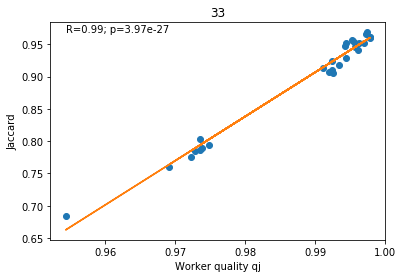

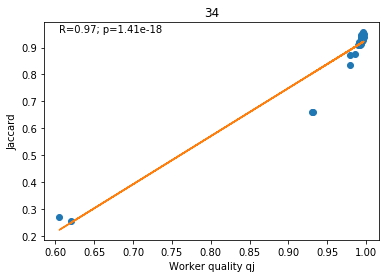

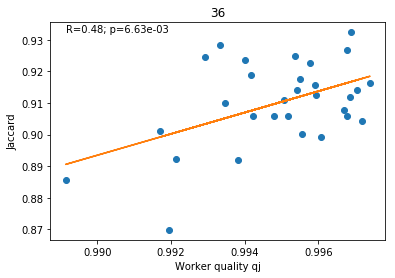

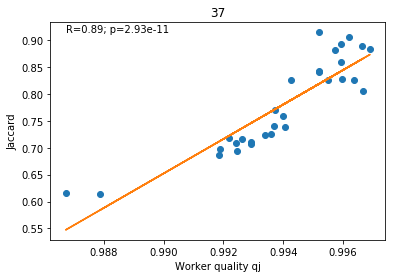

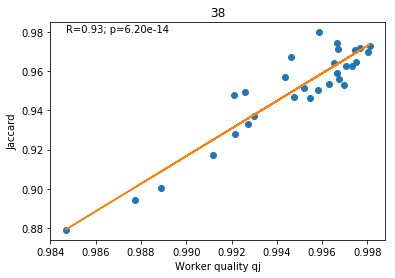

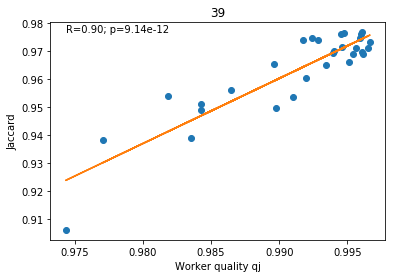

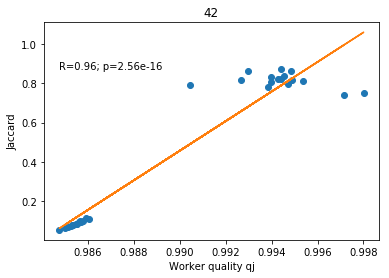

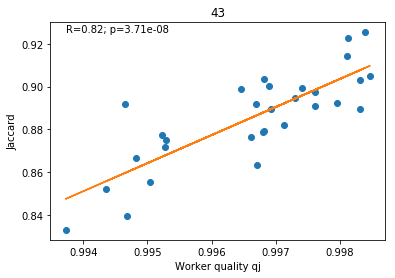

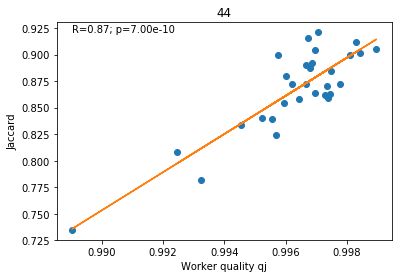

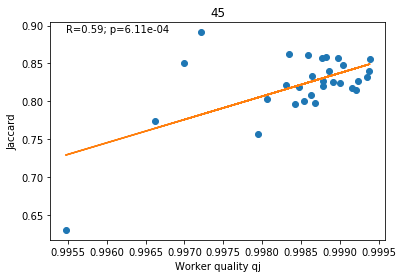

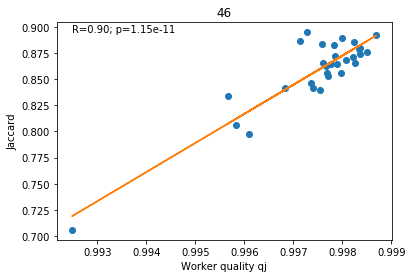

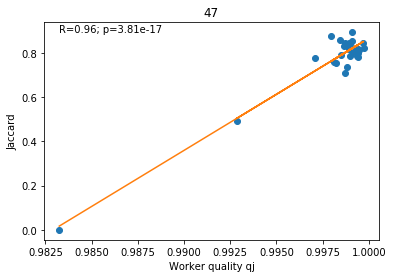

In [122]:
for objid in object_lst:
    selected_df = df[(df["sample"]=="30workers_rand0")&(df["objid"]==objid)&(df["clust"]=="-1")]
    plt.figure()
    plt.title(objid)
    x = np.array(selected_df["qj"])
    y = np.array(selected_df["Jaccard [Self]"])
    linresult = linregress(x,y)
    plt.plot(x,y,'o')
    plt.plot(x,linresult.slope*x+linresult.intercept,'-')
    plt.text(min(x),max(y),"R={:.2f}; p={:.2e}".format(linresult.rvalue,linresult.pvalue))
    plt.xlabel("Worker quality qj")
    plt.ylabel("Jaccard")
    # plt.xlim(0.95,1)

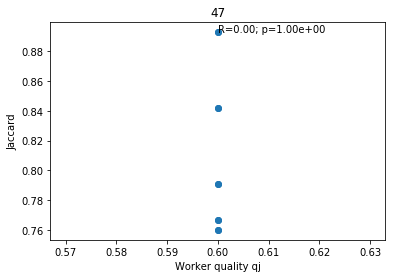

In [131]:
for objid in object_lst:
    selected_df = df[(df["sample"]=="30workers_rand0")&(df["objid"]==objid)&(df["clust"]=="-1")]
    plt.figure()
    plt.title(objid)
    x = np.array(selected_df["qj"])
    y = np.array(selected_df["Jaccard [Self]"])
    linresult = linregress(x,y)
    plt.plot(x,y,'o')
    plt.plot(x,linresult.slope*x+linresult.intercept,'-')
    plt.text(min(x),max(y),"R={:.2f}; p={:.2e}".format(linresult.rvalue,linresult.pvalue))
    plt.xlabel("Worker quality qj")
    plt.ylabel("Jaccard")
    # plt.xlim(0.95,1)